In [44]:
from tqdm import tqdm_notebook as tqdm
import numpy as np
import random as rand
import pandas as pd
import cv2
import os

import matplotlib.pyplot as plt
import pylab as labplt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

from keras.preprocessing.image import load_img

# Define params and helpers

In [94]:
img_size_ori = 101
img_num = 4000
augment_ratio = 1 # The images will expand images*augment_ratio

base_weight = 0.8
illusion_weight = 0.2

imgs_aug_path = './data/aug-1/images/'
masks_aug_path = './data/aug-1/masks/'

In [3]:
# load train set infomation
train_df = pd.read_csv("./data/train.csv", index_col="id", usecols=[0])
depths_df = pd.read_csv("./data/depths.csv", index_col="id")
train_df = train_df.join(depths_df)

In [4]:
# load train images
train_df["images"] = [np.array(load_img("./data/train/images/{}.png".format(idx), grayscale=True)) for idx in tqdm(train_df.index)]

# Load train masks

In [5]:
train_df["masks"] = [np.array(load_img("./data/train/masks/{}.png".format(idx), grayscale=True)) / 255 for idx in tqdm(train_df.index)]

# Calculate Coverage

In [6]:
train_df["coverage"] = train_df.masks.map(np.sum) / pow(img_size_ori, 2)

In [7]:
def cov_to_class(val):    
    for i in range(0, 11):
        if val * 10 <= i :
            return i
        
train_df["coverage_class"] = train_df.coverage.map(cov_to_class)

C:\Users\Natthawat\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\Natthawat\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,0,'Coverage class')

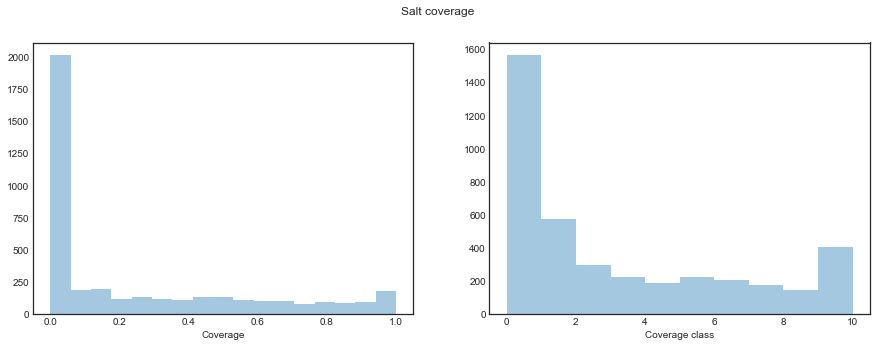

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
sns.distplot(train_df.coverage, kde=False, ax=axs[0])
sns.distplot(train_df.coverage_class, bins=10, kde=False, ax=axs[1])
plt.suptitle("Salt coverage")
axs[0].set_xlabel("Coverage")
axs[1].set_xlabel("Coverage class")

# Create roulette wheel for random imbalanced images

In [9]:
roulette_wheel = np.array((0))
slot_count = 0
 
def init_roul_wheel(value_array):
 
    slot_count = 0
    i=0
    arrsize = value_array.size
    while i < arrsize/2:
        slot_count = slot_count + value_array[2*i+1]
        i = i + 1
    roulette_wheel = np.zeros((slot_count),dtype=np.int)
    #print(roulette_wheel)
    i = 0
 
    while i < arrsize/2:
        rv = value_array[2*i]
        bv = value_array[2*i+1]
        j = 0
        while j<bv:
            t = rand.randint(0,slot_count-1)
            wheel_alloc = roulette_wheel[t]
            if wheel_alloc == 0:
                roulette_wheel[t] = rv
                j = j + 1
        i = i + 1
    return (roulette_wheel)
 
def spin(rw):
    slot_count = rw.size
    randno = rand.randint(0,10000)
    rot_degree = randno%360
    rot_unit = 360/slot_count
    rol_no = (rot_degree - (rot_degree%(rot_unit)))/rot_unit
    rol_value = rw[int(rol_no)]
    return rol_value    

In [26]:
coverage_wheel = []
for i in range(10):
    coverage_wheel.append(i)
    coverage_wheel.append(img_num // len(train_df[train_df['coverage_class'] == i]))

In [27]:
wheel_vector = np.array(coverage_wheel)
x = init_roul_wheel(wheel_vector)

In [28]:
cal_rounds = img_num * augment_ratio

In [78]:
results = np.zeros((cal_rounds),dtype=np.int)
imgs_aug = []
masks_aug = []
for i in range(cal_rounds):
    value = spin(x)
    base_df = train_df[train_df['coverage_class'] == value].iloc[[rand.randint(0, len(train_df[train_df['coverage_class'] == value]) - 1)]]
    ill_df = train_df.iloc[[rand.randint(0, img_num) - 1]]
    imgs_aug.append(np.abs(np.subtract(base_df['images'].values * base_weight, ill_df['images'].values * illusion_weight)))
    masks_aug.append(base_df['masks'])
    results[i] = value

In [79]:
# Show random coverage class ratio
unique, counts = np.unique(results, return_counts=True)
for i in range(10):
    #print (unique[i], "occured " + str(counts[i]))
    precentage = (counts[i]*100)/np.sum(counts)
    print ('coverage_class: ', unique[i]," precentage - ",str(precentage) + ' %','('+str(round(precentage))+')')

coverage_class:  0  precentage -  1.575 % (2.0)
coverage_class:  1  precentage -  3.4 % (3.0)
coverage_class:  2  precentage -  7.875 % (8.0)
coverage_class:  3  precentage -  10.125 % (10.0)
coverage_class:  4  precentage -  12.275 % (12.0)
coverage_class:  5  precentage -  11.35 % (11.0)
coverage_class:  6  precentage -  11.775 % (12.0)
coverage_class:  7  precentage -  12.775 % (13.0)
coverage_class:  8  precentage -  15.575 % (16.0)
coverage_class:  9  precentage -  13.275 % (13.0)


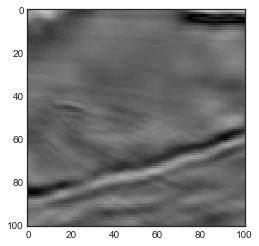

In [90]:
imgplot = plt.imshow(imgs_aug[500][0], cmap='gray')

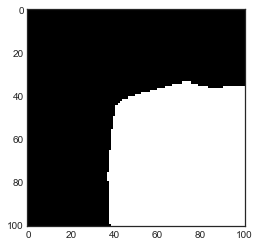

In [97]:
imgplot = plt.imshow(masks_aug[3999][0], cmap='gray')

# Save images

In [95]:
for i in range(cal_rounds):
    cv2.imwrite(imgs_aug_path + str(i) + '.jpg', imgs_aug[i][0])

In [108]:
for i in range(cal_rounds):
    mask_img = masks_aug[i][0] * 255
    cv2.imwrite(masks_aug_path + str(i) + '.jpg', mask_img)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.]])